# Xenium Human Lung Preview: Downstream Analysis

This notebook continues from the preprocessed `AnnData` object generated in **Notebook 1 (Ingestion & Matrix Construction)**.  
Here, we perform all **downstream analysis** steps on the Xenium Human Lung (FFPE, non-diseased) dataset.

**Workflow steps covered in this notebook:**
1. **Load processed data** (`adata_raw.h5ad`) created in Notebook 1.  
2. **Quality control (QC) filtering** using data-driven thresholds.  
3. **Normalization and transformation** (total-count scaling, log1p).  
4. **Feature selection**: identify highly variable genes (HVGs).  
5. **Dimensionality reduction** with PCA.  
6. **Clustering and visualization** (neighbor graph, UMAP, Leiden).  
7. **Spatial visualizations**: density maps, cluster overlays, feature expression.  
8. **Marker detection** with Wilcoxon tests and visualization (dotplots, heatmaps).  
9. **Spatial neighborhood analysis** using Squidpy (enrichment, connectivity).  

> **Note:** Make sure `adata_raw.h5ad` and `qc_metrics.csv` exist in your `results/` folder before running this notebook.


## Environment Setup and Imports

In this section we load all required Python packages for the downstream analysis.  
These include:

- **Core scientific stack:** `numpy`, `pandas`, `matplotlib`, `seaborn`  
- **Single-cell analysis:** `scanpy`, `anndata`  
- **Spatial analysis:** `squidpy`  
- **Sparse and data handling:** `scipy.sparse`, `pyarrow`  

We also configure:
- A fixed random seed for reproducibility.  
- Project paths for data, results, and figures.  
- Global plotting defaults for consistent visualization style.


In [1]:
# =========================
# Standard library imports
# =========================
from __future__ import annotations
import os
import sys
from datetime import datetime
from pathlib import Path

# ======================
# Third-party libraries
# ======================
import anndata as ad                  # core data structure
import matplotlib as mpl              # plotting engine
import matplotlib.pyplot as plt       # main plotting API
import numpy as np                    # numerics
import pandas as pd                   # tabular data
import scanpy as sc                   # single-cell analysis
import seaborn as sns                 # styled plots
import squidpy as sq                  # spatial transcriptomics
from matplotlib.colors import Normalize, LogNorm, PowerNorm  # color scaling
from scipy.sparse import issparse     # check sparse/dense arrays
from sklearn.metrics import silhouette_score
from matplotlib.lines import Line2D
import math

# =====================================
# Set global seed for reproducibility
# =====================================
import random
SEED = 123
random.seed(SEED)
np.random.seed(SEED)

# =====================================
# Global plotting settings
# =====================================

mpl.rcParams.update({
    "figure.figsize": (8, 8),
    "figure.facecolor": "black",
    "savefig.facecolor": "black",
    "axes.facecolor": "black",
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#666666",
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
    "axes.grid": True,           
})


def save_show_close(fig, outpath: Path, dpi: int = 300):
    fig.tight_layout()
    fig.savefig(outpath, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close(fig)

/home/juliors/.local/share/mamba/envs/xenium/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/juliors/.local/share/mamba/envs/xenium/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/juliors/.local/share/mamba/envs/xenium/lib/python3.11/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  retur

## Load processed AnnData

Load the preprocessed dataset (`adata_raw.h5ad`) created in Notebook 1 and set up paths for results and figures.


In [2]:
# Paths (adapt to your repo structure)
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parents[0]

DATA = ROOT / "data"
RESULTS = ROOT / "results"
FIGS = RESULTS / "figures"

# Load AnnData produced in Notebook 1
adata = ad.read_h5ad(RESULTS / "adata_raw.h5ad")

print(f"[LOAD] AnnData with {adata.n_obs:,} cells × {adata.n_vars:,} genes")


[LOAD] AnnData with 295,883 cells × 392 genes


## QC visualizations

Generate three plots to assess cell quality:

1. **Histogram of total counts per cell** – Shows distribution of read counts with x-axis labels every 50 units.  
2. **Histogram of detected genes per cell** – Displays distribution of gene counts with labels every 50 units.  
3. **Scatter plot of counts vs. genes** – Compares total counts and detected genes per cell to identify outliers or trends.

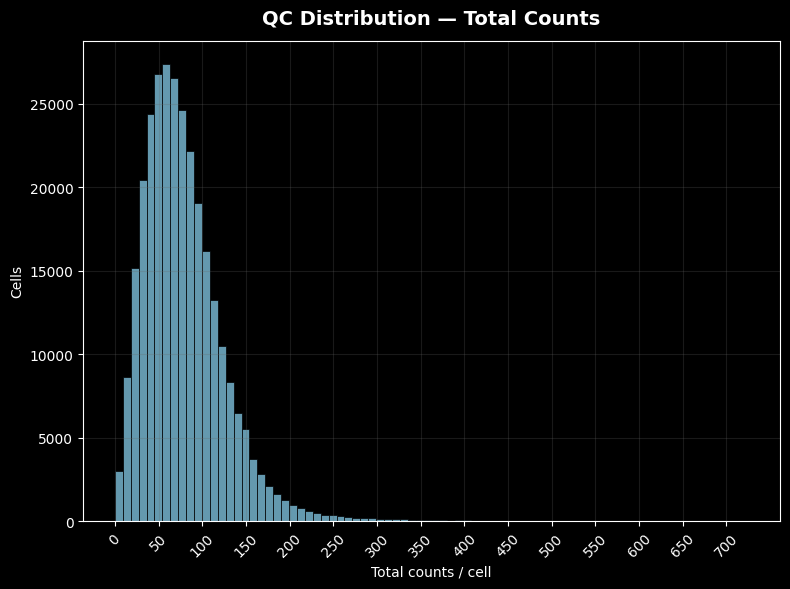

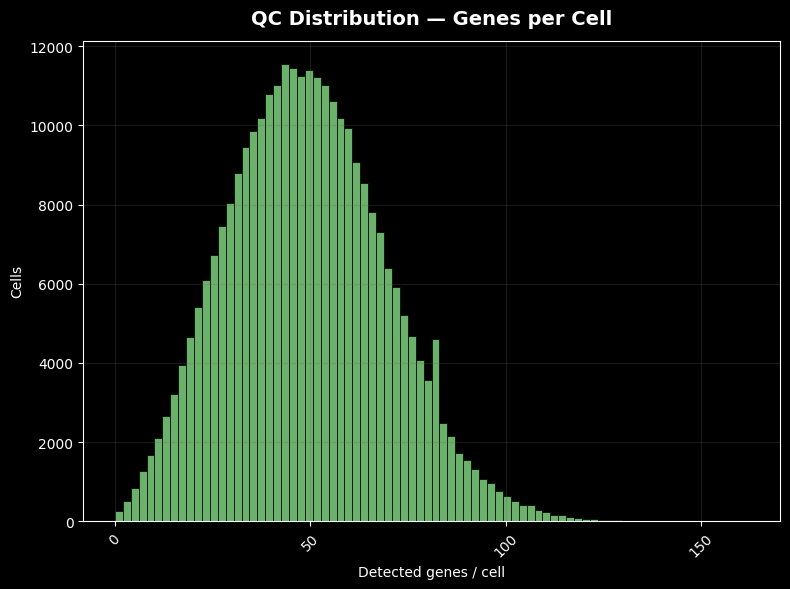

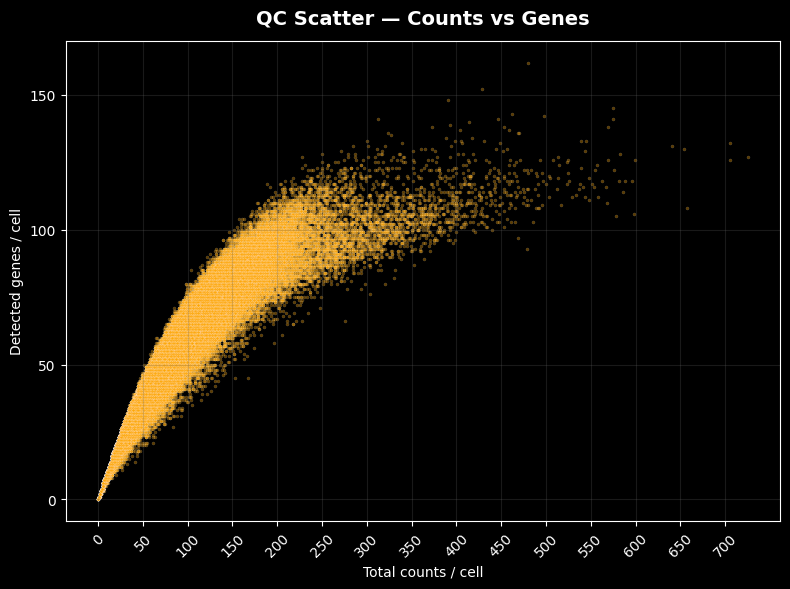

In [3]:
# --- Title helper ---
def set_plot_title(ax, title: str, fontsize: int = 14, color: str = "white"):
    ax.set_title(title, fontsize=fontsize, weight="bold", pad=12, color=color)

# -------- Figure 1 — QC distribution: total counts --------
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(adata.obs["total_counts"], bins=80, ax=ax, color="skyblue")
ax.set_xlabel("Total counts / cell")
ax.set_ylabel("Cells")
ax.set_title("QC Distribution — Total Counts", fontsize=14, weight="bold", pad=12, color="white")
max_x = float(adata.obs["total_counts"].max())
ax.set_xticks(np.arange(0, max_x + 1, 50))
plt.setp(ax.get_xticklabels(), rotation=45)
save_show_close(fig, FIGS / "01_qc_hist_total_counts.png")


# -------- Figure 2 — QC distribution: genes detected --------
fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(adata.obs["n_genes_by_counts"], bins=80, ax=ax, color="lightgreen")
ax.set_xlabel("Detected genes / cell")
ax.set_ylabel("Cells")
ax.set_title("QC Distribution — Genes per Cell", fontsize=14, weight="bold", pad=12, color="white")
max_x = float(adata.obs["n_genes_by_counts"].max())
ax.set_xticks(np.arange(0, max_x + 1, 50))
plt.setp(ax.get_xticklabels(), rotation=45)
save_show_close(fig, FIGS / "02_qc_hist_genes_per_cell.png")


# -------- Figure 3 — QC scatter: counts vs genes --------
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(
    x="total_counts", y="n_genes_by_counts",
    s=5, alpha=0.35, data=adata.obs, ax=ax, color="orange"
)
ax.set_xlabel("Total counts / cell")
ax.set_ylabel("Detected genes / cell")
ax.set_title("QC Scatter — Counts vs Genes", fontsize=14, weight="bold", pad=12, color="white")
max_x = float(adata.obs["total_counts"].max())
max_y = float(adata.obs["n_genes_by_counts"].max())
ax.set_xticks(np.arange(0, max_x + 1, 50))
ax.set_yticks(np.arange(0, max_y + 1, 50))
plt.setp(ax.get_xticklabels(), rotation=45)
save_show_close(fig, FIGS / "03_qc_scatter_counts_vs_genes.png")

## Adaptive QC Filtering

To retain high-quality cells, we apply **data-driven thresholds** based on the 1% quantile of the distributions:

- **Minimum counts per cell**: keep cells with at least the higher of (1% quantile, 50).  
- **Minimum genes per cell**: keep cells with at least the higher of (1% quantile, 15).  

If this strict filter discards all cells (e.g., for very sparse panels), a **fallback threshold** of `min_counts=10` and `min_genes=5` is applied.

After filtering, we create a new `AnnData` object and plot a **spatial density map** to visualize the retained cells.


[QC] min_counts=50.0, min_genes=15.0 → keep 212,528/295883
[QC] post-filter shape: (212528, 392)


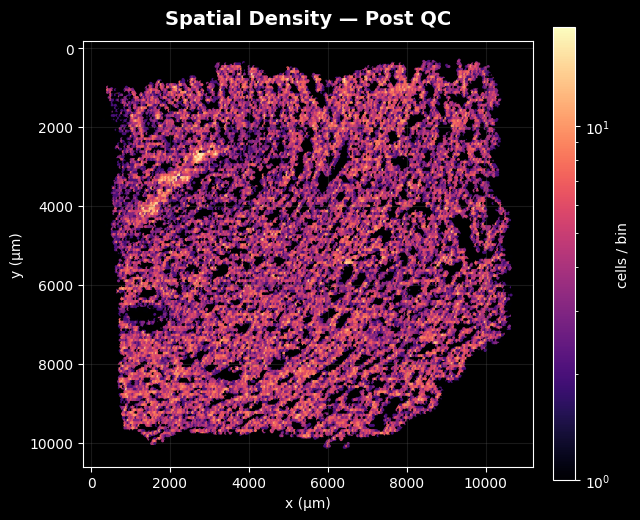

In [4]:
# -------------------------
# QC thresholds & filtering
# -------------------------
cnt = adata.obs["total_counts"]
ng  = adata.obs["n_genes_by_counts"]

min_counts = max(np.quantile(cnt, 0.01), 50)   # ≥ 1st percentile or 50
min_genes  = max(np.quantile(ng,  0.01), 15)   # ≥ 1st percentile or 15

keep = (cnt >= min_counts) & (ng >= min_genes)
n_keep = int(keep.sum())
print(f"[QC] min_counts={min_counts:.1f}, min_genes={min_genes:.1f} → keep {n_keep:,}/{adata.n_obs}")

if n_keep == 0:
    # Fallback if the panel is very sparse or distributions are odd
    min_counts, min_genes = 10, 5
    keep = (cnt >= min_counts) & (ng >= min_genes)
    n_keep = int(keep.sum())
    print(f"[QC][fallback] min_counts={min_counts}, min_genes={min_genes} → keep {n_keep:,}/{adata.n_obs}")
    assert n_keep > 0, "QC still yielded 0 cells; inspect distributions."

adata = adata[keep].copy()
print(f"[QC] post-filter shape: {adata.shape}")

# -----------------------------------------
# Figure 4 — Spatial density (post-QC, log)
# -----------------------------------------
xy = adata.obsm["spatial"]
x, y = xy[:, 0], xy[:, 1]

fig, ax = plt.subplots(figsize=(6.5, 6.5))

hb = ax.hexbin(x, y, gridsize=260, bins="log", mincnt=1, cmap="magma")

ax.invert_yaxis()
ax.set_aspect("equal", "box")
ax.set_xlabel("x (µm)")  # colors handled by rcParams
ax.set_ylabel("y (µm)")
ax.set_title("Spatial Density — Post QC", fontsize=14, weight="bold", pad=12, color="white")

# Colorbar styling (not covered by rcParams)
cb = fig.colorbar(hb, ax=ax, fraction=0.046, pad=0.04)
cb.set_label("cells / bin", color="white")
cb.ax.tick_params(colors="white")
cb.outline.set_edgecolor("white")

save_show_close(fig, FIGS / "04_spatial_density_post_qc.png")

## Normalization, Feature Selection, and Clustering

We now process the filtered dataset through the standard Scanpy pipeline:

1. **Normalization & log transform**  
   - Normalize each cell to a total of 10,000 counts.  
   - Apply log1p transformation to stabilize variance.  

2. **Highly variable genes (HVGs)**  
   - With small targeted panels, keep all genes or up to 3,000.  
   - Subset the matrix to HVGs for efficient analysis.  

3. **Principal Component Analysis (PCA)**  
   - Reduce dimensionality using up to 30 PCs (or fewer if the panel is small).  
   - Generate a scree plot to visualize explained variance.  

4. **Neighborhood graph, UMAP, and Leiden clustering**  
   - Build a k-nearest neighbor graph (15 neighbors, 12 PCs).  
   - Embed the data in 2D with UMAP (`min_dist=0.35`, `spread=1.0`).  
   - Perform community detection with Leiden clustering (`resolution=0.5`).  

This sets up the dataset for cluster-based and spatial analyses.


## PCA Scree & Elbow Plot

This code performs PCA on the normalized single-cell data and visualizes:

- **Per-PC variance (bars + line):** how much variance each principal component explains.  
- **Cumulative variance (green line):** total variance explained as PCs are added.  
- **Elbow point (yellow marker):** automatically detected using curvature (≈ PC5 here).  

The elbow gives a *lower bound* for the number of PCs to keep. In practice, scRNA-seq analyses usually use more PCs since biological signals are spread across multiple dimensions. The scree plot helps balance capturing meaningful variance while avoiding noise.



[PCA] elbow≈PC5 (cumulative variance: 0.141)


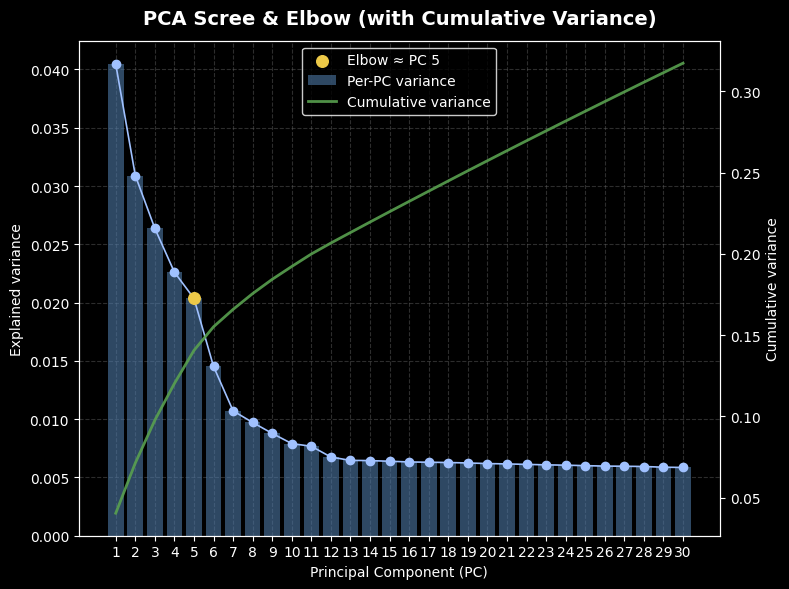

In [5]:
# --- Normalization & PCA ---
sc.pp.normalize_total(adata, target_sum=1e4)  # Normalize each cell to have total counts = 1e4
sc.pp.log1p(adata)                            # Apply log-transform to stabilize variance
sc.pp.highly_variable_genes(                  # Select top 3000 highly variable genes (or fewer if n_vars < 3000)
    adata, n_top_genes=min(3000, adata.n_vars), subset=True
)

# Choose number of principal components: up to 30, but not more than n_vars - 1
n_comps = min(30, max(2, adata.n_vars - 1))
sc.pp.pca(adata, n_comps=n_comps)             # Run PCA on the processed data

# --- Scree data ---
vr  = np.asarray(adata.uns["pca"]["variance_ratio"])  # Variance explained ratio per PC
pcs = np.arange(1, len(vr) + 1)                       # PC indices (1, 2, ..., n_comps)
cum = np.cumsum(vr)                                   # Cumulative variance explained

# --- Simple elbow heuristic ---
g2 = np.gradient(np.gradient(vr))          # Second derivative of variance ratios
elbow_idx = int(np.argmax(-g2))            # Elbow = point of maximum curvature
elbow_pc = pcs[elbow_idx]                  # PC index at the elbow
cum_at_elbow = float(cum[elbow_idx])       # Cumulative variance explained at elbow
print(f"[PCA] elbow≈PC{elbow_pc} (cumulative variance: {cum_at_elbow:.3f})")

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))     # Main figure + axis

# Bar plot of variance explained per PC
ax.bar(pcs, vr, alpha=0.6, width=0.8, label="Per-PC variance", color="#4E79A7")

# Overlay thin line for variance explained curve
ax.plot(pcs, vr, marker="o", lw=1.2, color="#A0C1FF")

# Highlight the elbow point with a scatter marker
ax.scatter([elbow_pc], [vr[elbow_idx]], s=70, color="#EDC948", zorder=5,
           label=f"Elbow ≈ PC {elbow_pc}")

# Add secondary y-axis for cumulative variance
ax2 = ax.twinx()
ax2.plot(pcs, cum, lw=2.0, alpha=0.9, color="#59A14F", label="Cumulative variance")

# Grid (avoid duplicate gridlines from twinx axis)
ax.grid(True, which="major", axis="both", linestyle="--", alpha=0.45)
ax.set_axisbelow(True)   # Draw grid behind bars/points
ax2.grid(False)          # Disable grid for secondary axis

# Axis labels and ticks
ax.set_xlabel("Principal Component (PC)")
ax.set_ylabel("Explained variance")
ax2.set_ylabel("Cumulative variance")
ax.set_xticks(pcs)

# Title
ax.set_title("PCA Scree & Elbow (with Cumulative Variance)",
             fontsize=14, weight="bold", pad=12, color="white")

# Legend: combine labels from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
leg = ax.legend(lines1 + lines2, labels1 + labels2, loc="upper center", frameon=True)

# Legend styling for dark background
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
for txt in leg.get_texts():
    txt.set_color("white")

# Save and close figure with helper
save_show_close(fig, FIGS / "05_pca_scree.png")


### Neighbors + UMAP + Leiden (11 PCs)

We build the neighborhood graph using **11 principal components**, then compute a 2D UMAP embedding for visualization. Finally, clustering is performed with the **Leiden algorithm** at resolution 0.5, which assigns cells into communities (stored in `adata.obs["leiden"]`). This step captures both the local structure of the data and the broader cellular diversity.

In [10]:
# Neighbors + UMAP + Leiden (13 PCs )
n_pcs = min(11, adata.obsm["X_pca"].shape[1])
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs, random_state=0)
sc.tl.umap(adata, min_dist=0.35, spread=1.0, random_state=0)


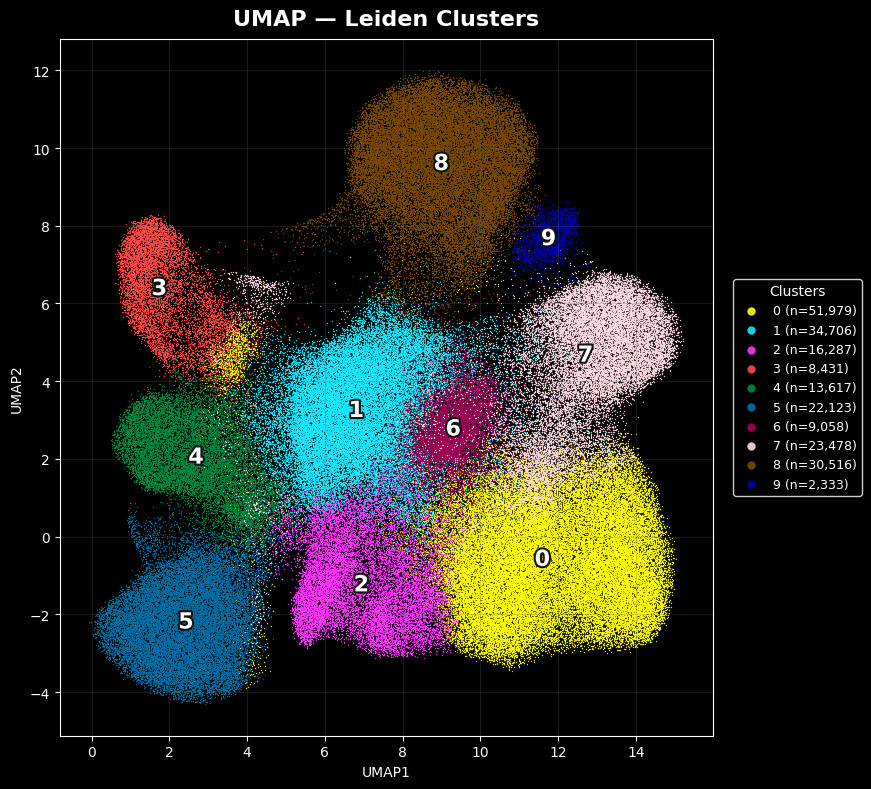

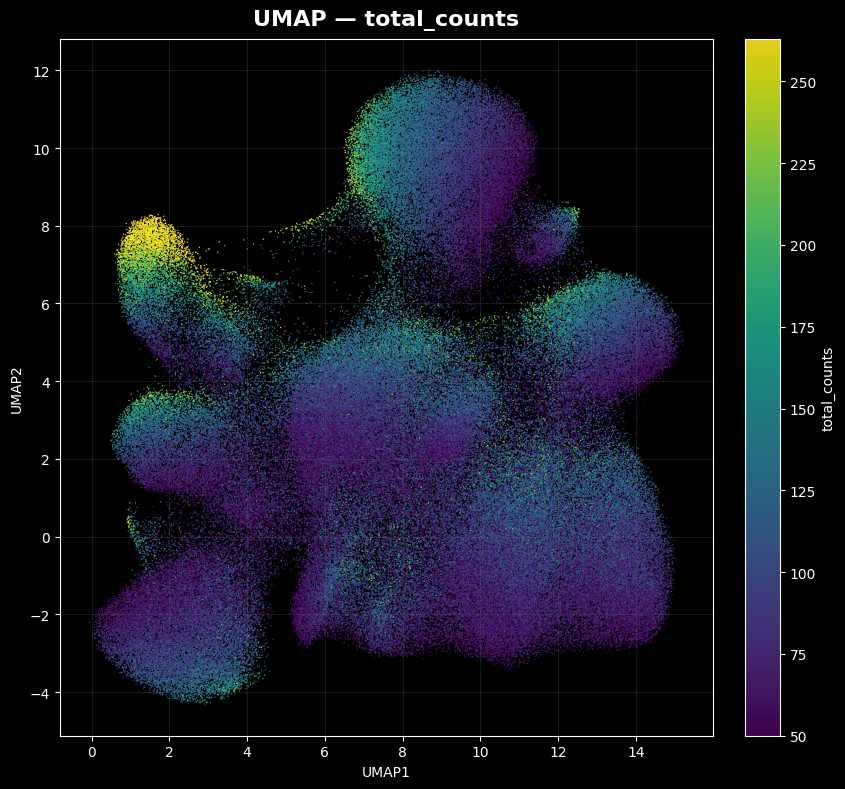

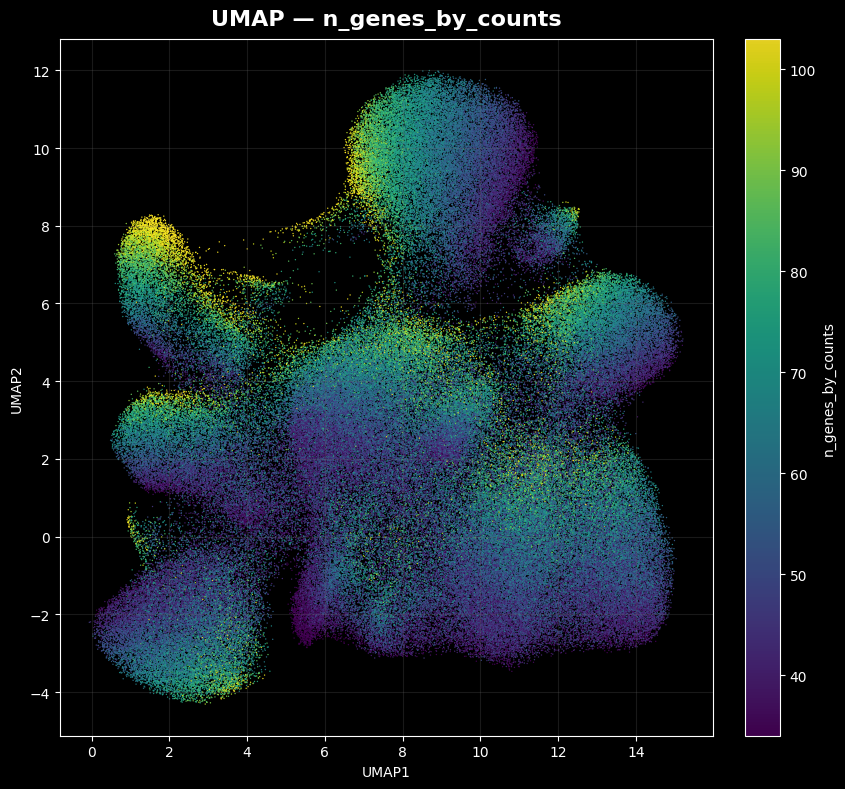

In [11]:
# Leiden clustering using igraph backend (stable + future-proof params)
sc.tl.leiden(
    adata,
    resolution=0.5,
    flavor="igraph",     # Explicitly request igraph backend
    n_iterations=2,      # Matches Scanpy’s upcoming default
    directed=False,      # Common setting for scRNA/Spatial graphs
    random_state=0       # Ensures reproducibility
)

# -----------------------------
# UMAP coordinates (already computed in adata)
# -----------------------------
XY = adata.obsm["X_umap"]     # Extract precomputed UMAP embedding
x, y = XY[:, 0], XY[:, 1]     # Split into x/y coordinates

# -----------------------------
# Helper: bold white title
# -----------------------------
def set_title(ax, text, fs=16):
    ax.set_title(text, fontsize=fs, weight="bold", color="white", pad=10)

# ============================================
# 1) UMAP — Leiden clusters with medoid labels
# ============================================
cats = adata.obs["leiden"].astype("category")         # Convert to categorical
cats = cats.cat.remove_unused_categories()            # Drop any empty clusters
palette = sc.plotting.palettes.default_102[: len(cats.cat.categories)]  # Distinct colors

fig, ax = plt.subplots(figsize=(9.8, 8))  # Slightly wider figure for side legend

# Plot each cluster separately (ensures crisp legend markers in PDF/PNG)
for k, cat in enumerate(cats.cat.categories):
    idx = (cats.values == cat)  # Boolean mask for cluster k
    ax.scatter(
        x[idx], y[idx],
        s=1.0, c=[palette[k]], lw=0, alpha=0.9,
        rasterized=True, label=f"{cat} (n={idx.sum():,})"
    )

# Compute cluster medoids (median UMAP position per cluster)
centroids = (
    pd.DataFrame({"x": x, "y": y, "c": cats.values})
    .groupby("c", observed=True)[["x", "y"]]
    .median()
)
# Add text labels at medoid positions
for lab, (cx, cy) in centroids.iterrows():
    ax.text(
        cx, cy, str(lab), ha="center", va="center",
        fontsize=16, fontweight="bold", color="white",
        path_effects=[mpl.patheffects.withStroke(linewidth=3, foreground="#111")]  # Outline for readability
    )

# Axis labels and equal aspect ratio
ax.set_xlabel("UMAP1", color="white")
ax.set_ylabel("UMAP2", color="white")
ax.set_aspect("equal", "box")
set_title(ax, "UMAP — Leiden Clusters")

# Legend placed outside the main plot (right side)
lines, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    lines, labels, title="Clusters",
    loc="center left", bbox_to_anchor=(1.02, 0.5),
    frameon=True, fontsize=9, markerscale=6/1.0, borderaxespad=0.6
)
# Dark background adjustments
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
leg.get_title().set_color("white")
for t in leg.get_texts():
    t.set_color("white")

# Save figure
fig.tight_layout()
fig.savefig(FIGS / "06_umap_leiden.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close(fig)

# =========================================================
# 2) UMAP — continuous overlays (for QC covariates, etc.)
# =========================================================
def umap_continuous(values, title, out_path, cmap="viridis"):
    """Plot UMAP colored by a continuous covariate, clipped at 1–99% percentiles."""
    vals = np.asarray(values, dtype=float)
    vmin, vmax = np.nanpercentile(vals, [1, 99])          # Robust range to reduce outlier effect
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=(9.0, 8.0))
    sca = ax.scatter(
        x, y, c=vals, s=1.0, cmap=cmap, norm=norm,
        lw=0, alpha=0.9, rasterized=True
    )
    ax.set_xlabel("UMAP1", color="white")
    ax.set_ylabel("UMAP2", color="white")
    ax.set_aspect("equal", "box")
    set_title(ax, f"UMAP — {title}")

    # Colorbar formatting for dark background
    cb = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.04)
    cb.outline.set_edgecolor("white")
    cb.ax.tick_params(labelsize=10, colors="white")
    cb.set_label(title, color="white")

    # Save and close
    fig.tight_layout()
    fig.savefig(out_path, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# Example calls for QC covariates
umap_continuous(adata.obs["total_counts"],      "total_counts",      FIGS / "07_umap_total_counts.png")
umap_continuous(adata.obs["n_genes_by_counts"], "n_genes_by_counts", FIGS / "07_umap_n_genes_by_counts.png")


### Spatial Visualization

We generate three complementary spatial plots to interpret cell clustering and gene expression in tissue context:

- **Figure 8 — Spatial Leiden Clusters**  
  Each cell is placed at its spatial coordinates and colored by Leiden cluster. Cluster IDs are also annotated at their median positions, helping to visualize the spatial organization of distinct cell populations.

- **Figure 10 — Spatial Feature Map (Single Gene)**  
  A selected gene (default: the first highly variable gene) is plotted across all spatial coordinates. Expression levels are color-coded with robust scaling, making it easier to detect local enrichment patterns even for lowly expressed genes.

Together, these plots connect **clustering results** with **spatial distribution** and **molecular features**, enabling biological interpretation of tissue architecture.


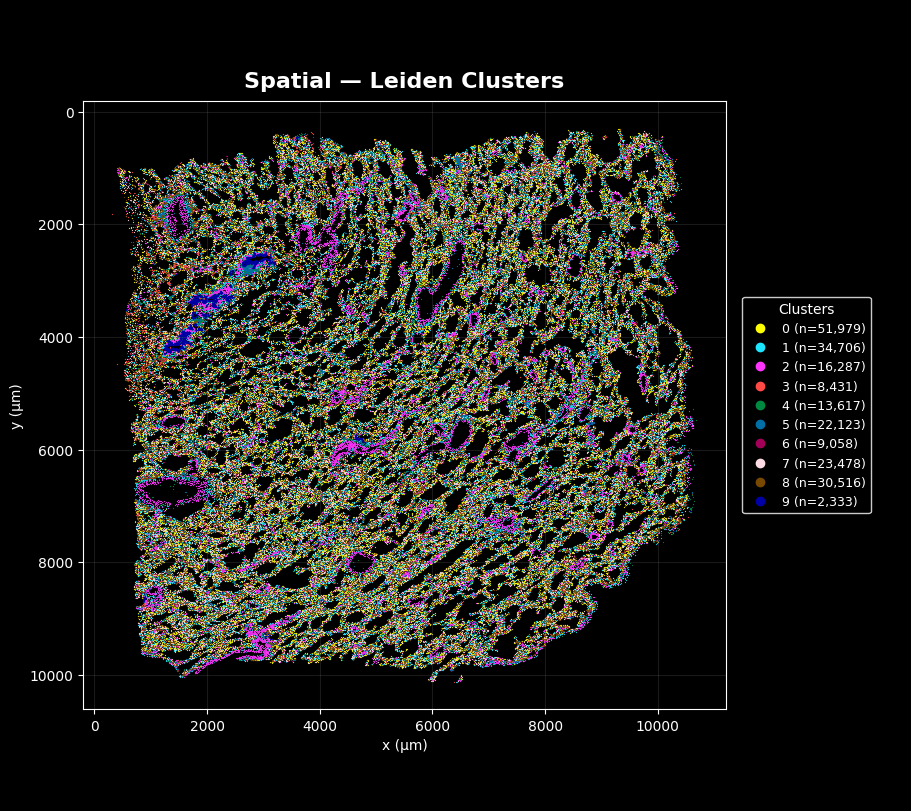

In [12]:
# -------------------------------------------------
# Spatial coordinates (once)
# -------------------------------------------------
xy = adata.obsm["spatial"]
x, y = xy[:, 0], xy[:, 1]

# ===============================================
# Figure 08 — Spatial: Leiden clusters (compact)
# ===============================================

# Extract cluster categories
cats = adata.obs["leiden"].astype("category").cat.remove_unused_categories()
codes = cats.cat.codes.to_numpy()                  # Numeric cluster codes
labels_cat = list(cats.cat.categories)             # Cluster labels
palette = sc.plotting.palettes.default_102[: len(labels_cat)]  # Distinct colors

# Figure with two subplots: main + legend panel
fig = plt.figure(figsize=(9.0, 8.0), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.26])   # Right column = legend
ax = fig.add_subplot(gs[0, 0])                          # Main plot
lg = fig.add_subplot(gs[0, 1]); lg.axis("off")          # Legend axis

# Scatter plot for each cluster
for k, col in enumerate(palette):
    m = (codes == k)
    if m.any():  # Plot only if cluster present
        ax.scatter(x[m], y[m], s=0.8, c=[col], lw=0, alpha=0.9, rasterized=True)

# Axes styling
ax.invert_yaxis()
ax.set_aspect("equal", "box")
ax.set_xlabel("x (µm)")   # color comes from rcParams
ax.set_ylabel("y (µm)")
ax.set_title("Spatial — Leiden Clusters", fontsize=16, weight="bold", pad=10, color="white")

# Legend construction (outside, right column)
counts = [int((codes == k).sum()) for k in range(len(labels_cat))]
labels = [f"{lab} (n={cnt:,})" for lab, cnt in zip(labels_cat, counts)]
# Proxy markers for legend
proxies = [
    Line2D([0], [0], marker="o", lw=0, markersize=6,
           markerfacecolor=palette[k], markeredgecolor=palette[k])
    for k in range(len(labels_cat))
]
leg = lg.legend(
    proxies, labels, title="Clusters", loc="center left",
    frameon=True, fontsize=9, borderaxespad=0.6
)

# Legend styling for dark background
lg.set_facecolor("black")
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
leg.get_title().set_color("white")
for t in leg.get_texts():
    t.set_color("white")

# Save and show
fig.savefig(FIGS / "08_spatial_leiden.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close(fig)


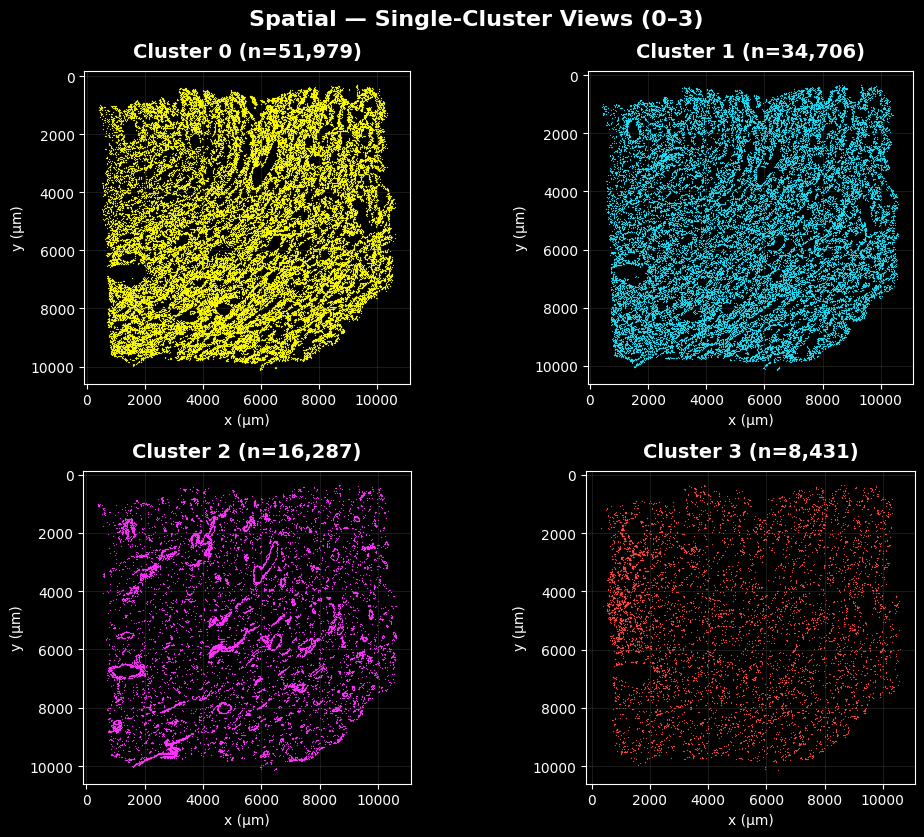

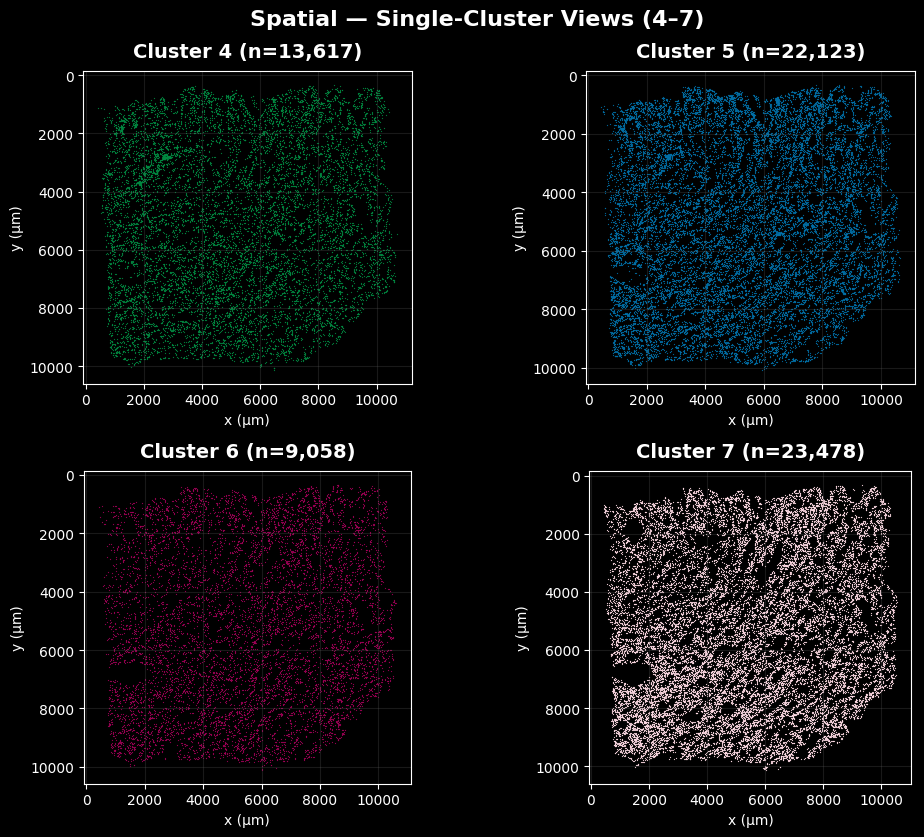

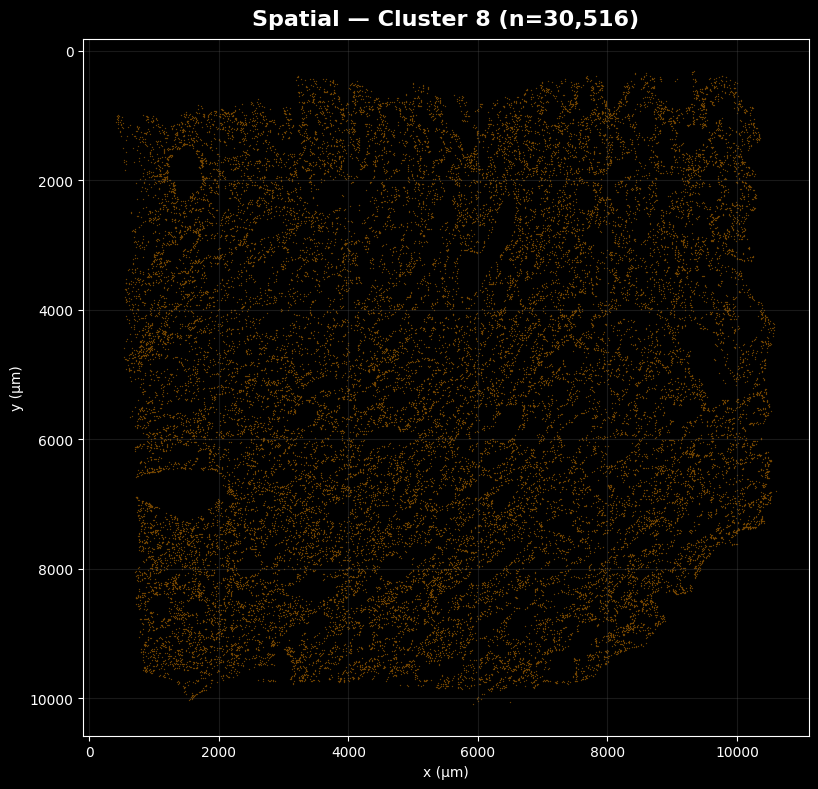

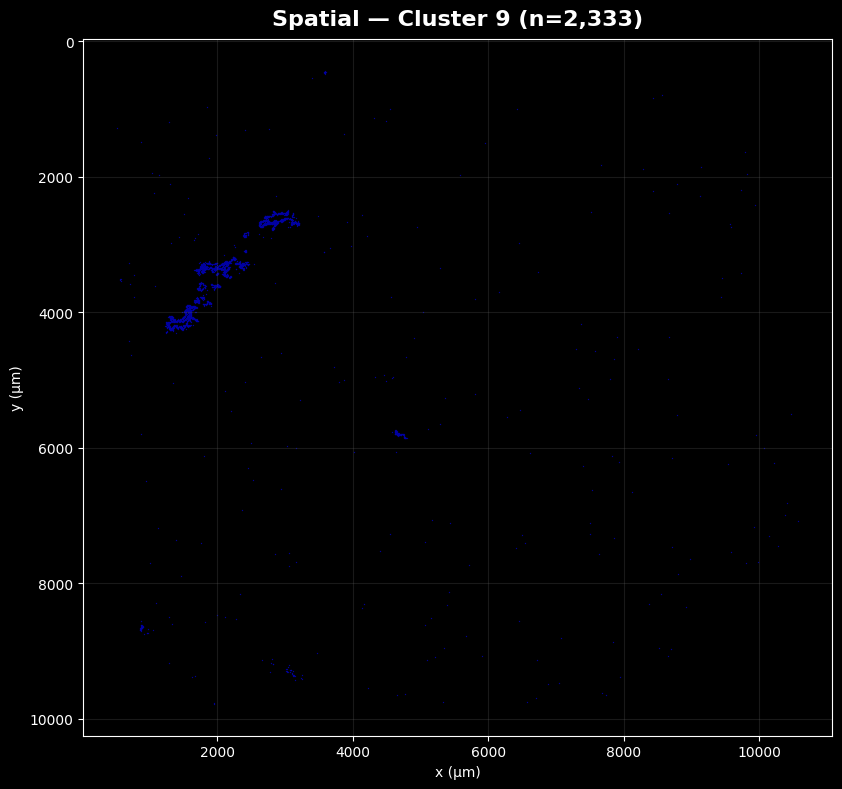

In [13]:


# Title helper (in case not defined)
try:
    set_title
except NameError:
    def set_title(ax, text, fs=16):
        ax.set_title(text, fontsize=fs, weight="bold", color="white", pad=10)

# -------------------------------------------------
# Prep: cluster codes, labels, palette
# -------------------------------------------------
cats = adata.obs["leiden"].astype("category").cat.remove_unused_categories()
labels_cat = list(cats.cat.categories)              # e.g. ['0','1',...,'8']
codes = cats.cat.codes.to_numpy()                   # integer codes aligned to labels_cat
n_clusters = len(labels_cat)
palette = sc.plotting.palettes.default_102[:n_clusters]

# convenience: count per cluster and boolean masks
counts = {k: int((codes == k).sum()) for k in range(n_clusters)}
masks  = {k: (codes == k) for k in range(n_clusters)}

# -------------------------------------------------
# Helper to draw a grid of single-cluster subplots
# -------------------------------------------------

def plot_cluster_grid(cluster_ids, filename, suptitle):
    """Draw each cluster in `cluster_ids` as its own subplot (single-color points only)."""
    # layout: 2x2; if fewer than 4, hide empty panels
    rows, cols = 2, 2
    fig, axes = plt.subplots(rows, cols, figsize=(10.5, 8.5))
    axes = np.array(axes).reshape(rows, cols)

    for i in range(rows * cols):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        if i < len(cluster_ids):
            k = cluster_ids[i]
            m = masks.get(k, None)
            if m is None or not np.any(m):
                ax.axis("off")
                continue

            ax.scatter(
                x[m], y[m],
                s=0.8, c=[palette[k]], lw=0, alpha=0.9, rasterized=True
            )
            ax.invert_yaxis()
            ax.set_aspect("equal", "box")
            ax.set_xlabel("x (µm)", color="white")
            ax.set_ylabel("y (µm)", color="white")
            set_title(ax, f"Cluster {labels_cat[k]} (n={counts[k]:,})", fs=14)
        else:
            ax.axis("off")

    fig.suptitle(suptitle, fontsize=16, weight="bold", color="white", y=0.98)
    fig.tight_layout()
    fig.savefig(FIGS / filename, dpi=600, bbox_inches="tight")
    plt.show()
    plt.close(fig)

# -------------------------------------------------
# Make the two 2×2 grids and the final single plot
# -------------------------------------------------
# 1) clusters 0–3
plot_cluster_grid([0, 1, 2, 3], "08a_spatial_clusters_0_3.png",
                  "Spatial — Single-Cluster Views (0–3)")

# 2) clusters 4–7
plot_cluster_grid([4, 5, 6, 7], "08b_spatial_clusters_4_7.png",
                  "Spatial — Single-Cluster Views (4–7)")

# 3) cluster 8 (single figure)
fig, ax = plt.subplots(figsize=(8.6, 8.0))
k = 8
m = masks.get(k, None)
if m is not None and np.any(m):
    ax.scatter(x[m], y[m], s=0.9, c=[palette[k]], lw=0, alpha=0.9, rasterized=True)
    ax.invert_yaxis()
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x (µm)", color="white")
    ax.set_ylabel("y (µm)", color="white")
    set_title(ax, f"Spatial — Cluster {labels_cat[k]} (n={counts[k]:,})")
    fig.tight_layout()
    fig.savefig(FIGS / "08c_spatial_cluster_8.png", dpi=600, bbox_inches="tight")
    plt.show()
    plt.close(fig)
else:
    plt.close(fig)
    print("Cluster 8 not found or empty; skipped final plot.")
# 4) cluster 9 (single figure)
fig, ax = plt.subplots(figsize=(8.6, 8.0))
k = 9
m = masks.get(k, None)
if m is not None and np.any(m):
    ax.scatter(x[m], y[m], s=0.9, c=[palette[k]], lw=0, alpha=0.9, rasterized=True)
    ax.invert_yaxis()
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x (µm)", color="white")
    ax.set_ylabel("y (µm)", color="white")
    set_title(ax, f"Spatial — Cluster {labels_cat[k]} (n={counts[k]:,})")
    fig.tight_layout()
    fig.savefig(FIGS / "08d_spatial_cluster_9.png", dpi=600, bbox_inches="tight")
    plt.show()
    plt.close(fig)
else:
    plt.close(fig)
    print("Cluster 9 not found or empty; skipped final plot.")

### Spatial Cell-type Maps

- **Figure 9 — Cell-type Scores (2×2)**  
  Using curated marker panels (Epithelial, Endothelial, Stromal, Immune), per-cell z-scored averages are mapped to show spatial enrichment of each lineage.

- **Figure 10 — Major Compartments (high-marker cells)**  
  Cells in the top 25% of marker expression per compartment are highlighted, giving a clear spatial map of dominant epithelial, endothelial, stromal, and immune regions.


[Epithelial] using 5/13 markers; missing: ABCA3, CAV1, MUC5AC, SCGB1A1, SFTPA1, SFTPA2, SFTPC, SLC34A2
[Endothelial] using 6/9 markers; missing: EDNRB, EMCN, PECAM1
[Stromal] using 5/12 markers; missing: ACTA2, COL1A1, COL1A2, COL3A1, DCN, LUM, TAGLN
[Immune] using 10/16 markers; missing: GNLY, LYZ, MRC1, MS4A7, PTPRC, TRAC


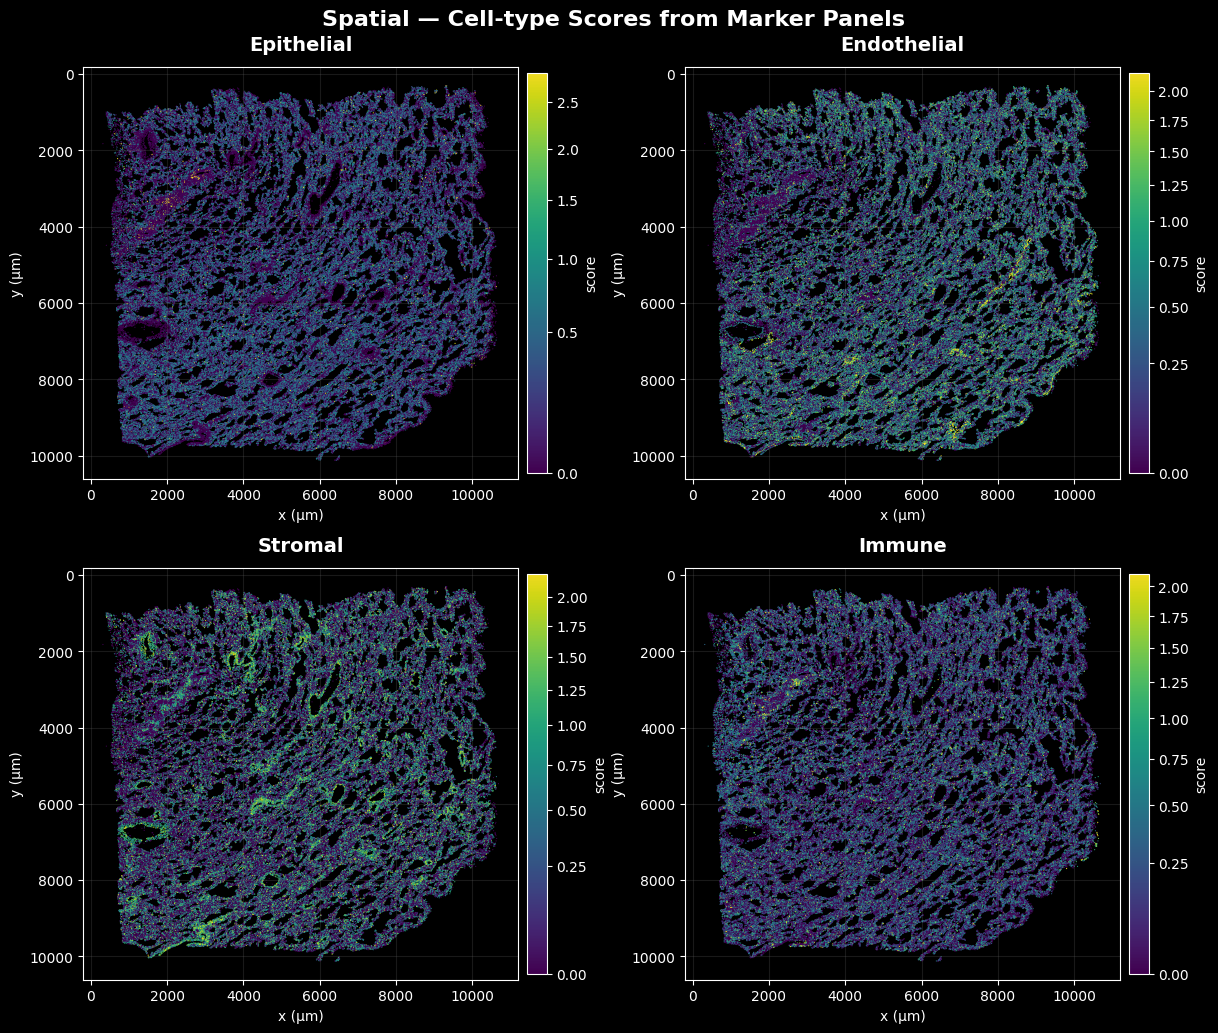

In [14]:
# ===========================================================
# Figure 09 — Spatial: cell-type scores (2×2) from marker sets
# ===========================================================


# --- Marker sets (curated) ---
markers = {
    "Epithelial": [
        # AT1
        "AGER","PDPN","CAV1",
        # AT2
        "SFTPC","SFTPA1","SFTPA2","SLC34A2","ABCA3",
        # Airway support
        "KRT5","TP63","SCGB1A1","MUC5AC","MUC5B",
    ],
    "Endothelial": [
        # pan-vascular
        "PECAM1","CLDN5","VWF","KDR","EMCN",
        # alveolar capillary/aerocyte
        "CA4","EDNRB",
        # lymphatic
        "LYVE1","PROX1",
    ],
    "Stromal": [
        # fibroblasts
        "COL1A1","COL1A2","COL3A1","LUM","DCN","PDGFRA",
        # smooth muscle / myofibroblast
        "ACTA2","TAGLN","MYH11",
        # pericytes
        "PDGFRB","RGS5","CSPG4",
    ],
    "Immune": [
        # pan-immune
        "PTPRC",
        # T cells
        "CD3D","CD3E","TRAC","CD4","CD8A",
        # B / Plasma
        "MS4A1","CD79A","MZB1",
        # Myeloid / Macrophage
        "MRC1","MARCO","LYZ","MS4A7",
        # NK
        "NKG7","GNLY","KLRD1",
    ],
}

# --- Data sources ---
XY = adata.obsm["spatial"]
x, y = XY[:, 0], XY[:, 1]

# We'll score on the current adata.X (normalized/log1p from your pipeline)
X = adata.X
if issparse(X):
    X = X.tocsr()

# Utility: z-score each selected gene across cells and average (ignore NaNs)
def gene_scores_from_panel(panel):
    present = [g for g in panel if g in adata.var_names]
    missing = sorted(set(panel) - set(present))
    if len(present) == 0:
        return np.zeros(adata.n_obs), present, missing

    # extract expression matrix for markers (cells x genes)
    idx = adata.var_names.get_indexer(present)
    M = X[:, idx] if issparse(X) else X[:, idx]

    # to dense (marker subset is small; safe)
    M = M.toarray() if issparse(M) else np.asarray(M)

    # z-score per gene across cells (add tiny eps to std)
    mu = np.nanmean(M, axis=0)
    sd = np.nanstd(M, axis=0)
    sd[sd < 1e-8] = 1e-8
    Z = (M - mu) / sd

    # mean z across markers (ignore NaNs)
    score = np.nanmean(Z, axis=1)

    # clamp low tail to 0 for nicer PowerNorm on dark bg
    floor = np.nanpercentile(score, 1)
    score = score - floor
    score[score < 0] = 0.0

    return score, present, missing

# Compute scores and keep some accounting
group_names = ["Epithelial", "Endothelial", "Stromal", "Immune"]
scores = []
used = {}
miss = {}

for g in group_names:
    scv, present, missing = gene_scores_from_panel(markers[g])
    scores.append(scv)
    used[g] = present
    miss[g] = missing
    print(f"[{g}] using {len(present)}/{len(markers[g])} markers; missing: {', '.join(missing) if missing else '—'}")

# --- Plot 2×2 spatial maps (dark-theme friendly) ---
fig, axes = plt.subplots(2, 2, figsize=(12.0, 10.0), constrained_layout=True)
axes = axes.flat

for ax, name, vals in zip(axes, group_names, scores):
    # robust scaling per panel
    vmax = np.nanpercentile(vals[vals > 0], 99) if np.any(vals > 0) else 1.0
    norm = PowerNorm(gamma=0.6, vmin=0.0, vmax=vmax)

    sca = ax.scatter(x, y, c=vals, s=0.7, lw=0, cmap="viridis", norm=norm,
                     alpha=0.95, rasterized=True)

    ax.invert_yaxis()
    ax.set_aspect("equal", "box")
    ax.set_xlabel("x (µm)", color="white")
    ax.set_ylabel("y (µm)", color="white")
    ax.set_title(name, fontsize=14, weight="bold", color="white", pad=12)

    cb = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
    cb.set_label("score", color="white")
    cb.outline.set_edgecolor("white")
    cb.ax.tick_params(colors="white")

# In case some panels are fewer than 4 (shouldn't happen), hide extras
for ax in axes[len(group_names):]:
    ax.axis("off")

fig.suptitle("Spatial — Cell-type Scores from Marker Panels",
    x=0.5, 
    y=1.02,           # default is ~0.98 — pushing it higher
    fontsize=16,
    weight="bold",
    color="white"
)
fig.savefig(FIGS / "09_spatial_celltype_scores.png", dpi=600, bbox_inches="tight")
plt.show()
plt.close(fig)

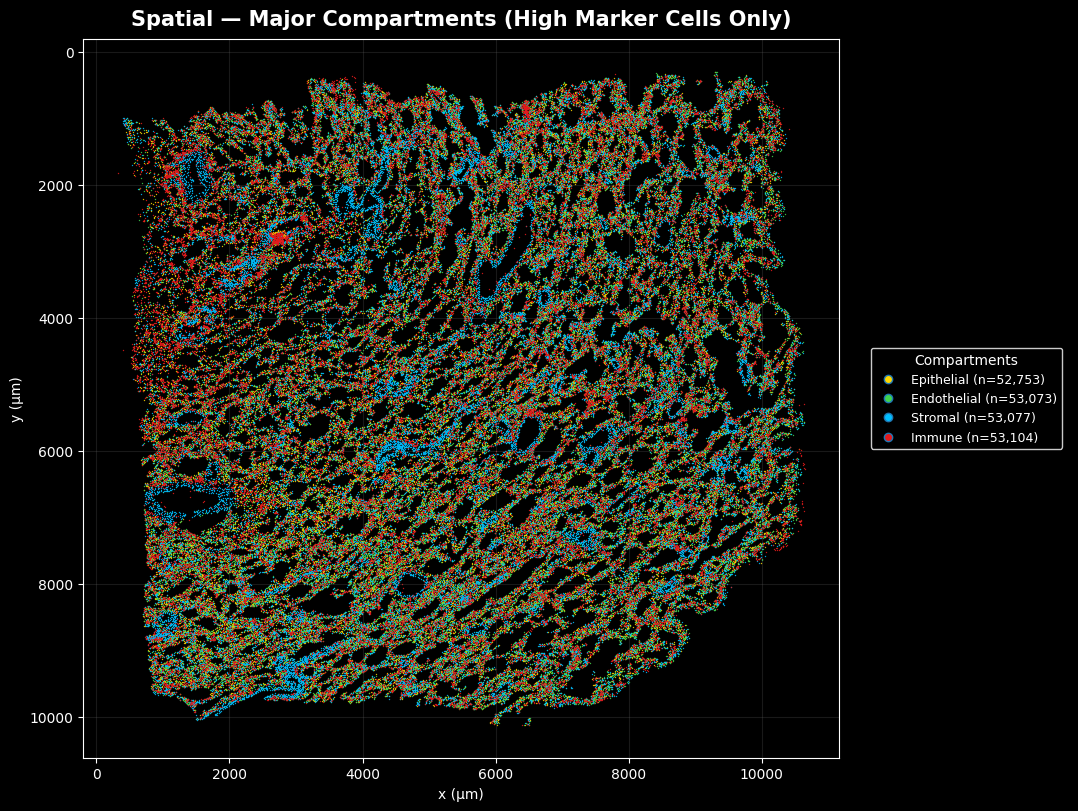

In [24]:
# ===============================================
# Figure 10 — Spatial: Major Cell Compartments 
# ===============================================


# Data
xy = adata.obsm["spatial"]
x, y = xy[:, 0], xy[:, 1]

# Compute scores (mean across available genes) -> ALWAYS 1-D ndarray
scores = {}
for comp, genes in markers.items():
    valid = [g for g in genes if g in adata.var_names]
    if not valid:
        continue
    subX = adata[:, valid].X
    if issparse(subX):
        s = np.asarray(subX.mean(axis=1)).ravel()   # sparse -> ndarray (n,)
    else:
        s = np.asarray(subX).mean(axis=1).ravel()   # dense -> ndarray (n,)
    scores[comp] = s

# Threshold high-signal cells (e.g., top 25% per compartment)
high_idx = {}
for c, s in scores.items():
    # ensure 1-D float array for quantile
    s1d = np.asarray(s, dtype=float).ravel()
    thr = np.quantile(s1d, 0.75)
    high_idx[c] = (s1d > thr)

# Palette
colors = {
    "Epithelial":  "#FFD700",  
    "Endothelial": "#40D44E",  
    "Stromal":     "#00BFFF",  
    "Immune":      "#e41a1c",  
}
# ---- Figure with legend on the right ----
fig = plt.figure(figsize=(10.8, 8.0), constrained_layout=True)
gs = fig.add_gridspec(1, 2, width_ratios=[1.0, 0.26])
ax = fig.add_subplot(gs[0, 0])
leg_ax = fig.add_subplot(gs[0, 1]); leg_ax.axis("off")

proxies, labels = [], []
for comp in ["Epithelial", "Endothelial", "Stromal", "Immune"]:
    if comp not in high_idx:   # skip compartments with no valid markers
        continue
    idx = high_idx[comp]
    if np.any(idx):
        ax.scatter(x[idx], y[idx], s=1.0, c=colors[comp], lw=0, alpha=0.85, rasterized=True)
        proxies.append(Line2D([0], [0], marker="o", lw=0,
                              markerfacecolor=colors[comp], markersize=6))
        labels.append(f"{comp} (n={int(idx.sum()):,})")

# Style
ax.invert_yaxis()
ax.set_aspect("equal", "box")
ax.set_xlabel("x (µm)", color="white")
ax.set_ylabel("y (µm)", color="white")
ax.set_title("Spatial — Major Compartments (High Marker Cells Only)",
             fontsize=15, weight="bold", color="white", pad=10)

leg = leg_ax.legend(proxies, labels, title="Compartments",
                    loc="center left", frameon=True, fontsize=9)
leg_ax.set_facecolor("black")
leg.get_frame().set_facecolor("black")
leg.get_frame().set_edgecolor("white")
leg.get_title().set_color("white")
for t in leg.get_texts():
    t.set_color("white")

fig.savefig(FIGS / "10_spatial_compartments_high.png", dpi=600, bbox_inches="tight")
plt.show(); plt.close(fig)


### Cluster Marker Analysis

- **Figure 11 — Dotplot of Top Markers**  
  For each Leiden cluster, the top four differentially expressed genes (Wilcoxon test) are shown as a dotplot, summarizing expression strength and detection rate.

- **Figure 12 — Heatmap of Top Markers**  
  The same markers are displayed as a heatmap, normalized per gene across clusters. This highlights expression patterns and helps compare marker specificity between clusters.


In [25]:
# Markers
# Find cluster markers (Wilcoxon rank-sum)
# This will compute per-cluster DE genes using the 'leiden' labels you already computed.
sc.tl.rank_genes_groups(
    adata, 
    groupby="leiden", 
    method="wilcoxon", 
    use_raw=False
)
# Figure 11 — Dotplot of top markers
# Use return_fig=True so we can save cleanly without tight_layout warnings.
fig = sc.pl.rank_genes_groups_dotplot(
    adata, 
    n_genes=4, 
    show=False, 
    return_fig=True
)
fig.savefig(FIGS / "11_markers_dotplot.png", dpi=220, bbox_inches="tight")
plt.close()

# Figure 12 — Heatmap of top markers
fig = sc.pl.rank_genes_groups_heatmap(
    adata, 
    n_genes=4, 
    show=False, 
    use_raw=False, 
    swap_axes=True,        # often easier to read
    dendrogram=False, 
    standard_scale="var"   # normalize genes across clusters
)
plt.gcf().savefig(FIGS / "12_markers_heatmap.png", dpi=220, bbox_inches="tight")
plt.close()

### Spatial Neighborhood Enrichment

- **Figure 13 — Neighborhood Enrichment Heatmap**  
  A spatial graph is built using cell coordinates (radius ≈30 µm), defining local neighborhoods.  
  Neighborhood enrichment tests whether Leiden clusters occur near each other more or less often than expected by chance.  
  The heatmap shows over-enrichment (red) or under-enrichment (blue) of cluster–cluster interactions, highlighting spatial relationships between cell types.


In [27]:

# Build spatial graph from your coordinates in adata.obsm['spatial'] (units: microns)
# radius: choose ~25–35 µm for Xenium cell neighborhoods; tweak if too sparse/dense
sq.gr.spatial_neighbors(
    adata,
    coord_type="generic",   # coordinates are in plain x/y (not pixel indices)
    spatial_key="spatial",
    radius=30.0,            # try 25–35
    n_rings=1,              # one-ring neighborhoods
    set_diag=False
)

# Neighborhood enrichment requires permutations (must be > 0).
# 100 is fast-ish and gives stable z-scores; you can raise later to 1000 for publication.
sq.gr.nhood_enrichment(
    adata, 
    cluster_key="leiden", 
    n_perms=100, 
    show_progress_bar=False
)
# Figure 13 — Neighborhood enrichment heatmap
# Shows over/under-representation of cluster pairs in each other's neighborhood.
fig = sq.pl.nhood_enrichment(
    adata, 
    cluster_key="leiden", 
    show=False, 
    cmap="coolwarm", 
    vmin=-5, vmax=5  # clip extremes for readability
)
plt.gcf().savefig(FIGS / "13_nhood_enrichment.png", dpi=220, bbox_inches="tight")
plt.close()

### Cluster Abundance and Key Markers

- **Figure 14 — Cluster Size Barplot**  
  Shows the number of cells in each Leiden cluster, providing a quick view of population abundance.

- **Figure 15 — Top Markers per Cluster**  
  A compact dotplot of the top three genes per cluster, ranked by differential expression.  
  This highlights key markers that distinguish each cluster.


In [29]:
# Figure 14 — Cluster size barplot
# Helpful to see abundance per cluster
counts = adata.obs["leiden"].value_counts().sort_index()
plt.figure(figsize=(6,3))
counts.plot(kind="bar")
plt.ylabel("cells")
plt.title("Cluster sizes (Leiden)")
plt.tight_layout()
plt.savefig(FIGS / "14_cluster_sizes.png", dpi=220)
plt.close()
# Figure 15 — Top marker per cluster (dotplot subset)
# Extract top gene names per cluster and plot a compact dotplot.
top = 3
marker_df = sc.get.rank_genes_groups_df(adata, group=None)
top_markers = (marker_df
               .sort_values(["group", "pvals_adj"])
               .groupby("group")
               .head(top)["names"]
               .unique().tolist())

fig = sc.pl.dotplot(
    adata, 
    var_names=top_markers, 
    groupby="leiden", 
    show=False, 
    standard_scale="var"
)
plt.gcf().savefig(FIGS / "15_top_marker_dotplot.png", dpi=220, bbox_inches="tight")
plt.close()

/tmp/ipykernel_40921/455566524.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")
